In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

## TODO: Add the preprocessing steps from https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.94_May2022/SpikeInterface_Tutorial.ipynb

# Chapter 2: Preprocessing Recording

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import importlib

In [3]:
from collections import defaultdict
import time
import json

In [220]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from scipy import stats

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_1568033/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [10]:
import spikeinterface.full as si

In [11]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/recording_raw})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/recording_raw})`. You would replace `{./path/to/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [12]:
all_recording_raw_directories = glob.glob("./proc/**/recording_raw", recursive=True)

In [13]:
all_recording_raw_directories

['./proc/subject_6_1_omission_and_competition_with_6_3/recording_raw']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [14]:
# To be used for all steps
recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_raw_directories[0])
# To be used when referencing the original raw recording
recording_raw = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_raw_directories[0])


## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...



In [15]:
channel_ids = recording_raw.get_channel_ids()
fs = recording_raw.get_sampling_frequency()
num_chan = recording_raw.get_num_channels()
num_seg = recording_raw.get_num_segments()
duration = recording_raw.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 64113600
Number of hours: 0.8904666666666666


- Looking over the probe

In [16]:
probe_object = recording_raw.get_probegroup()

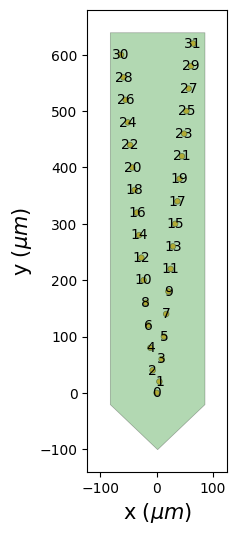

In [17]:
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

# Part 2: Preprocessing

- Preproccessing the signal to improve the spike sorting performance

- **NOTE**: If you want to add preprocessing steps, you must either make additional code cells to a similar format as below or change the `Raw NBConvert` cells into `Code` cells.
    - Here are more available steps: https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing/plot_1_preprocessing.html#sphx-glr-modules-preprocessing-plot-1-preprocessing-py
- **NOTE**: If you want to remove preprocessing steps, you must turn unneeded `Code` cells into `Raw NBConvert` cells.
- **NOTE**: If you want to reorder the preprocessing steps, you must reorder the `Code` cells by clicking on the up or down arrow on the top menu when you have the `Code` cell clicked.

- All available preprocessing methods shown below:

In [18]:
for method in dir(st.preprocessing):
    print(method)


__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__


In [100]:
preprocessing_step_dict = defaultdict(dict)

In [101]:
preprocessing_step_dict["recording_raw"] = recording_raw

- Bandpass filter to only get the LFP

In [102]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_bandpass = st.bandpass_filter(recording_intermediate, freq_min=1, freq_max=300)
recording_intermediate = st.bandpass_filter(recording_intermediate, freq_min=1, freq_max=300)
preprocessing_step_dict["recording_bandpass"] = recording_bandpass
print(recording_bandpass)

BandpassFilterRecording: 32 channels - 1 segments - 1.0kHz - 3205.680s


- Resampling to lower the number of samples

In [103]:
recording_raw.sampling_frequency

20000.0

In [104]:
resampled_frequency = 1000

In [105]:
original_to_resampled_frequency_ratio = resampled_frequency / recording_raw.sampling_frequency

In [106]:
original_to_resampled_frequency_ratio

0.05

In [107]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_resample = st.resample(recording_intermediate, resampled_frequency)
recording_intermediate = st.resample(recording_intermediate, resampled_frequency)
preprocessing_step_dict["recording_resample"] = recording_resample
print(recording_resample)

ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3205.680s


In [108]:
recording_resample.frame_slice(3204*1000,3205*1000+1)

FrameSliceRecording: 32 channels - 1 segments - 1.0kHz - 1.001s

In [109]:
preprocessing_step_dict

defaultdict(dict,
            {'recording_raw': BinaryFolderRecording: 32 channels - 1 segments - 20.0kHz - 3205.680s,
             'recording_bandpass': BandpassFilterRecording: 32 channels - 1 segments - 1.0kHz - 3205.680s,
             'recording_resample': ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3205.680s})

# Part 3: Visualization and EDA

## Plotting the Time Series

- Plotting with lines are better for recordings with smaller channel numbers

In [110]:
time_difference = 1

In [111]:
start_time = int(27998597/20000 - 0.5)

In [112]:
time_range = [start_time, start_time + time_difference] 

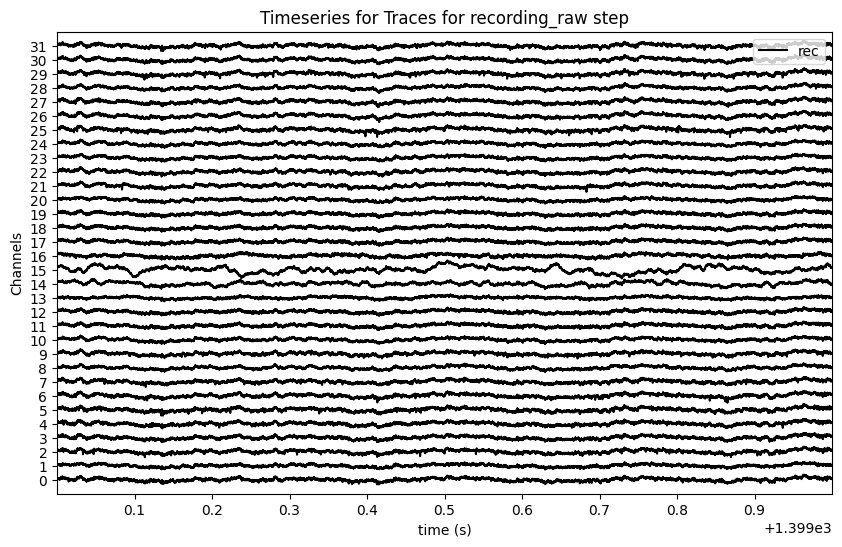

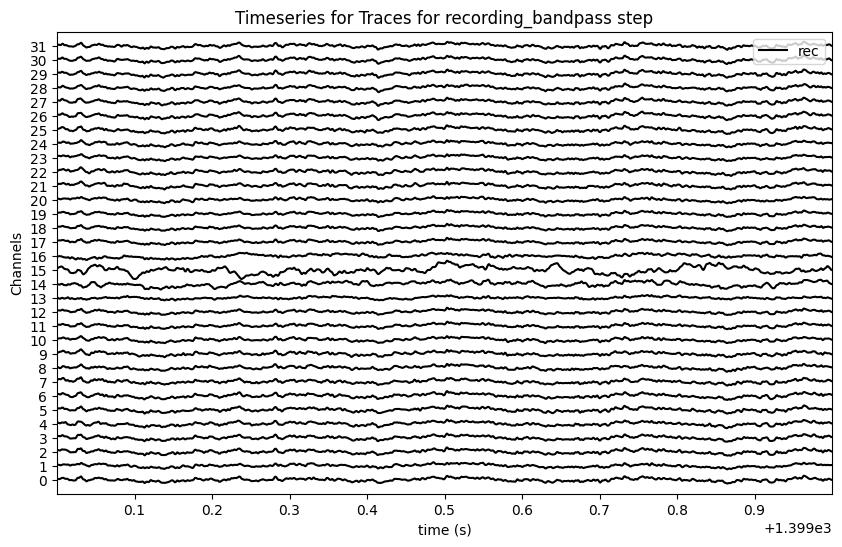

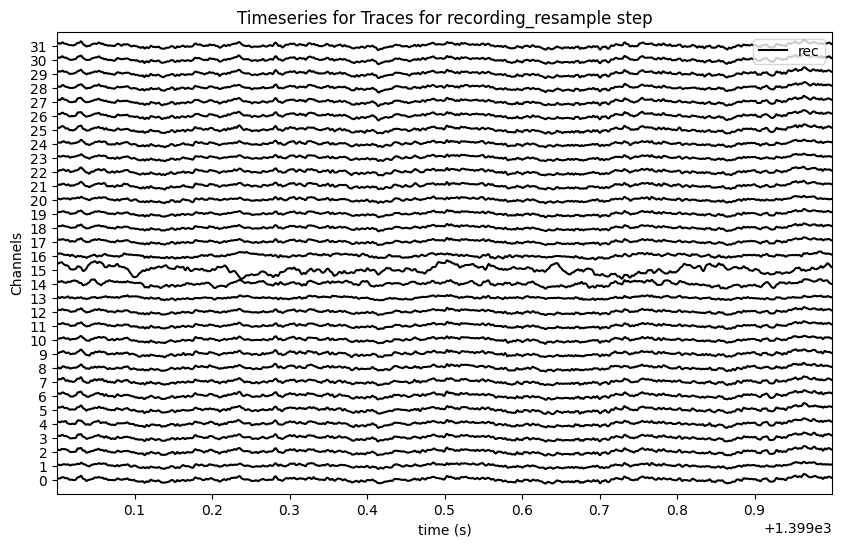

In [113]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), show_channel_ids=True) #, figure=fig)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    plt.show()

- Looking more closely at a few of the channels
    - The Channel IDs:

In [114]:
recording_intermediate.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2')

In [117]:
channel_ids = np.random.choice(recording_intermediate.channel_ids, size=5, replace=False)

In [118]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

In [119]:
channel_ids

['8', '14', '22', '23', '26']

- If you want to use a specific set of channels, change the channels in the cell below and turn it into a `Code` cell

In [121]:
# Best channels with current setup
channel_ids = ["31", "21", "15", "14", "13"]

- With Raw Recording

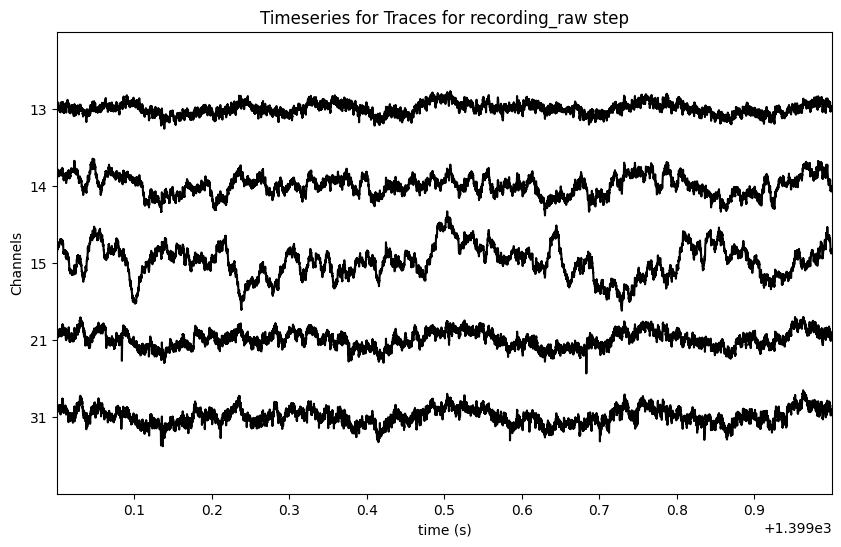

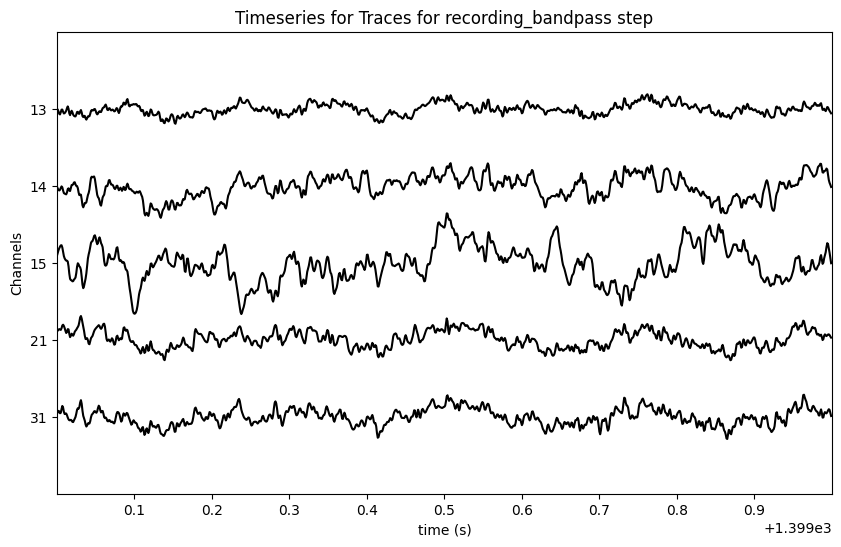

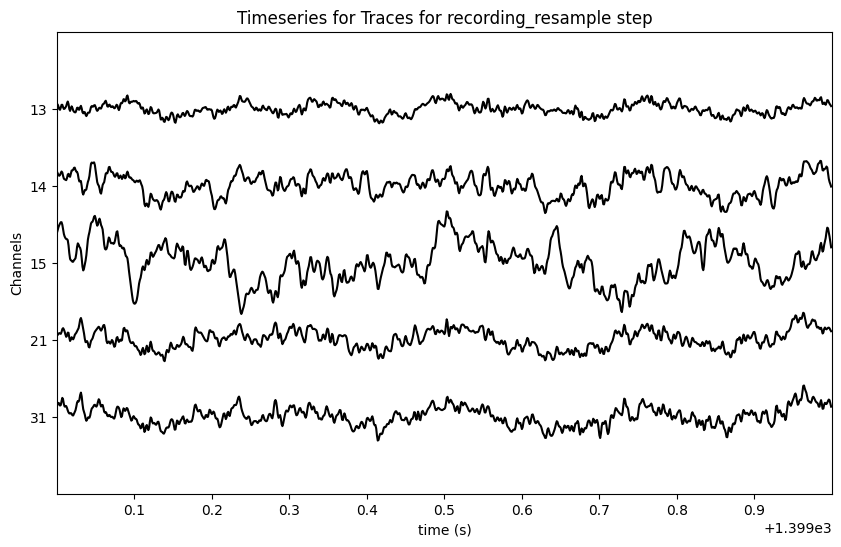

In [122]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    
    plt.legend().remove()
    plt.savefig("./proc/cmr_plot_{}.svg".format(key))
    plt.savefig("./proc/cmr_plot_{}.png".format(key))
    plt.show()

- Heat map is better for high channel counts

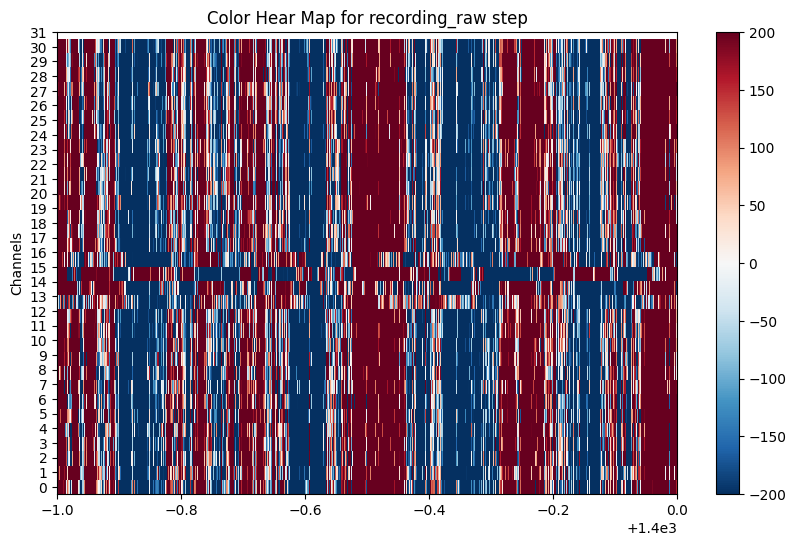

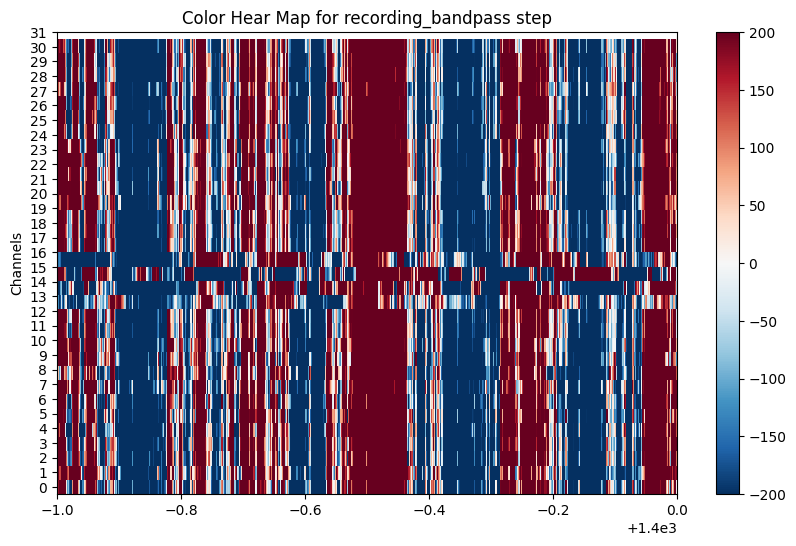

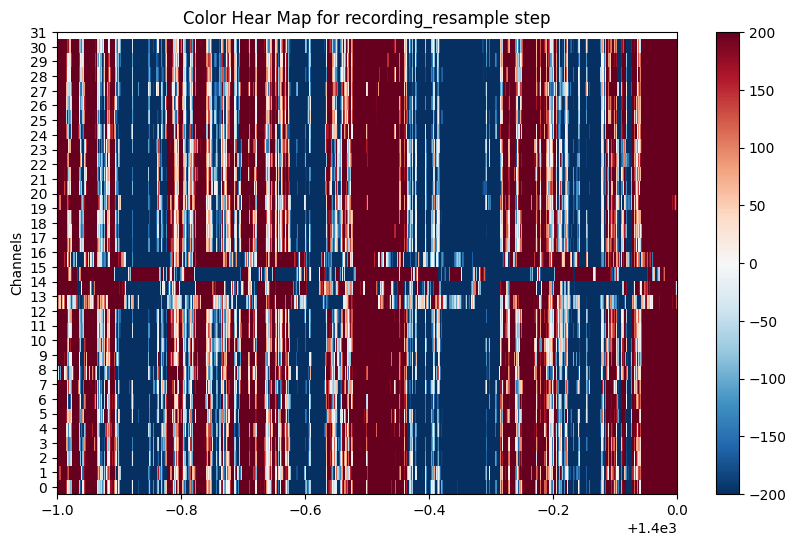

In [123]:
for key, value in preprocessing_step_dict.items():
    w_ts = sw.plot_timeseries(value, time_range=time_range, mode="map", show_channel_ids=True)
    plt.title("Color Hear Map for {} step".format(key))
    plt.ylabel("Channels")
    plt.show()


# Plotting Power and Coherence

In [124]:
from spectral_connectivity import Multitaper, Connectivity



In [125]:
recording_intermediate.get_traces(start_frame=3205*1000, end_frame=3205*1000+1)

array([[ 408,  106,  325,  242,  367,  338,  272,  328,  139,  104,  164,
           0,   24, -326, -853, -757, -482,    0,   59,   21,  165,  -28,
          -8,  104,   37,  350,  350,  255,  288,  284,  368,  276]],
      dtype=int16)

In [135]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=recording_intermediate.get_traces(channel_ids=["21"], start_frame=1000*1000, end_frame=1010*1000),
               sampling_frequency=resampled_frequency)



In [136]:
# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)



In [137]:
# Here are a couple of examples
power = c.power() # spectral power

In [138]:
coherence = c.coherence_magnitude()


In [139]:
weighted_phase_lag_index = c.weighted_phase_lag_index()


In [140]:
power.max()

21583.833347269796

In [141]:
power.min()

0.0016179896016602726

- Test Code

(0.0, 200.0)

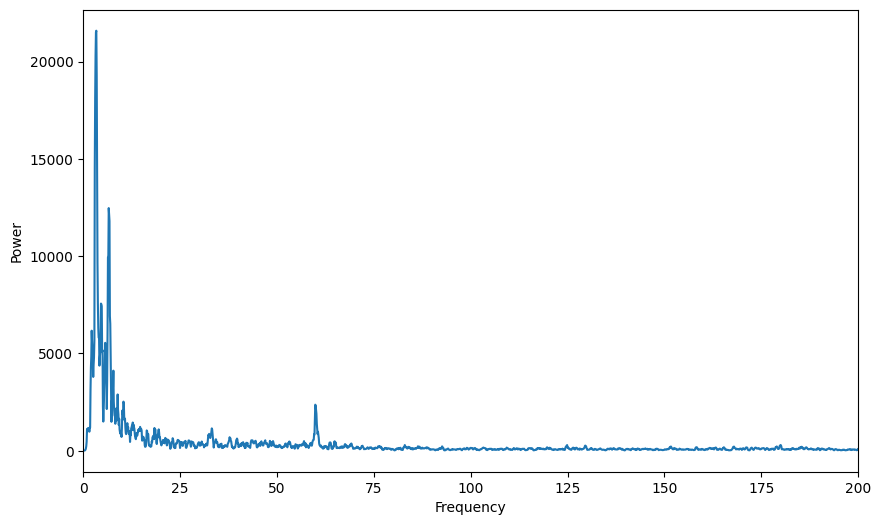

In [142]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,200)

(0.0, 80.0)

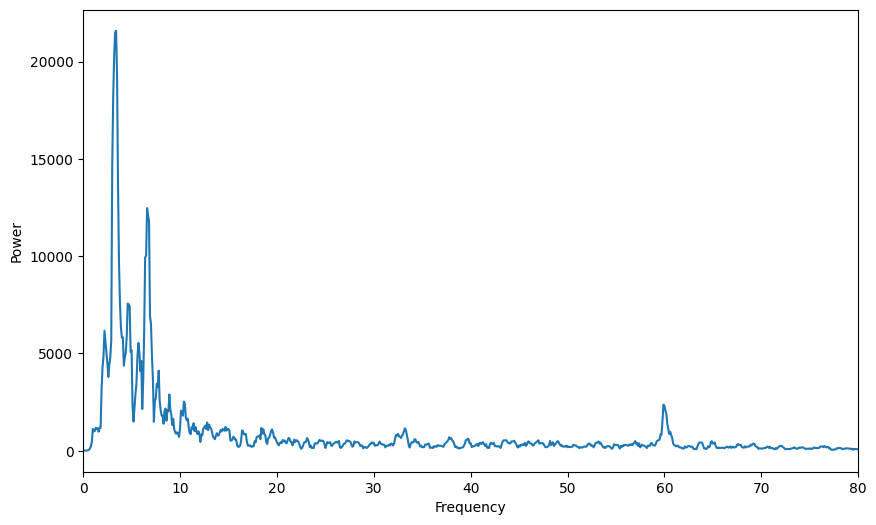

In [143]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,80)

## Sync up the tone times with the LFP

In [157]:
tone_label_df = pd.read_csv("./proc/subj_6_1_date_20221214_tone_label_df.csv", index_col=0)

In [158]:
tone_label_df["resampled_timestamps"] = (tone_label_df["tone_time_stamp"] * original_to_resampled_frequency_ratio).astype(int)

In [159]:
tone_label_df

,tone_time_stamp,tone_category,resampled_timestamps
0,1408048,rewarded,70402
1,3008051,rewarded,150402
2,4808043,rewarded,240402
3,6408042,omission,320402
4,7908040,rewarded,395402
5,9908037,rewarded,495401
6,11808035,rewarded,590401
7,13608031,rewarded,680401
8,15208032,omission,760401
9,17008029,rewarded,850401


### Winning

In [165]:
winning_resampled_timestamps = tone_label_df[tone_label_df["tone_category"] == "win"]["resampled_timestamps"]

In [166]:
winning_resampled_timestamps

15    1479929
16    1569929
17    1649929
18    1724929
19    1824929
20    1919929
21    2009929
22    2089929
23    2179929
24    2279928
25    2369928
30    2849928
Name: resampled_timestamps, dtype: int64

- Power reduces shape from 10000 to 5000

In [235]:
winning_power_list = []
winning_frequencies_list = []
for time_stamp in winning_resampled_timestamps:
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_series=recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*10))

    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    winning_power_list.append(c.power().squeeze())
#     winning_frequencies_list.append(c.frequencies)

    

In [236]:
winning_traces_array = np.vstack(winning_power_list)

In [237]:
winning_traces_array.shape

(12, 5000)

In [238]:
c.frequencies.shape

(5000,)

In [239]:
c.frequencies

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.997e+02, 4.998e+02,
       4.999e+02])

In [191]:
c.power().squeeze().shape

(5000,)

In [204]:
np.mean(winning_traces_array, axis = 0)

array([1.24423886e+01, 1.26307358e+01, 1.35106426e+01, ...,
       1.93950425e-03, 1.91264002e-03, 1.86148543e-03])

In [210]:
ste_traces_array

6.823661553436639

In [217]:
winning_traces_array[0]

array([2.28720024e+01, 2.33935900e+01, 2.51803260e+01, ...,
       2.54496491e-03, 2.67097788e-03, 2.19672516e-03])

/tmp/ipykernel_1568033/969557559.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,60000)


(0.0004975834788896719, 60000)

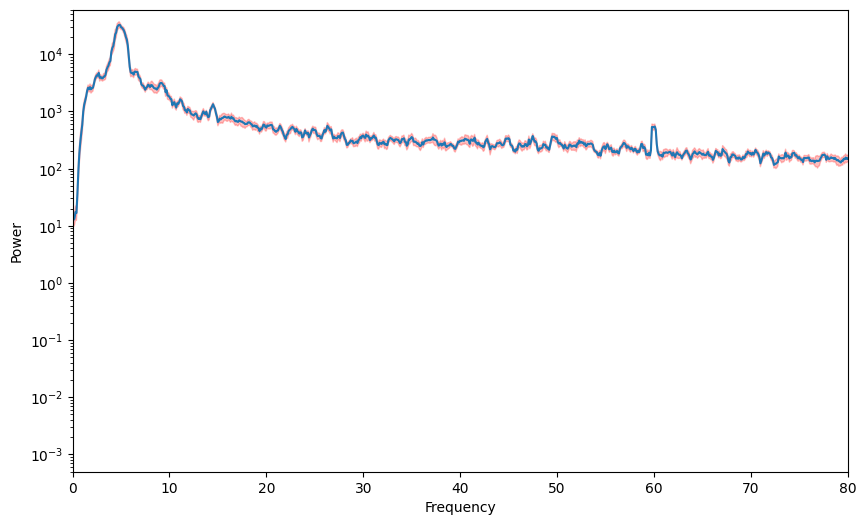

In [229]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
mean_traces_array = np.mean(winning_traces_array, axis = 0)
ste_traces_array = stats.sem(winning_traces_array)


ax.plot(c.frequencies, np.mean(winning_traces_array, axis = 0))
ax.fill_between(c.frequencies, np.mean(winning_traces_array, axis = 0)-ste_traces_array, \
                    np.mean(winning_traces_array, axis = 0)+ste_traces_array, \
                   alpha=.25, color="r")
ax.set_xlim(0,80)
ax.set_yscale("log")
ax.set_ylim(0,60000)

### For all labels

In [224]:
tone_label_to_timestamps = defaultdict(dict)
for tone_label in tone_label_df["tone_category"].unique():
    tone_label_to_timestamps[tone_label]["resampled_timestamps"] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [248]:
recording_traces[:resampled_frequency*10].shape

(10000, 1)

In [249]:
recording_traces

array([[-303],
       [-207],
       [-132],
       ...,
       [-337],
       [-590],
       [-556]], dtype=int16)

In [252]:
duration = 10
for tone_label in tone_label_df["tone_category"].unique():
    print(tone_label)
    tone_label_to_timestamps[tone_label]["power_list"] = []
    tone_label_to_timestamps[tone_label]["frequency_list"] = []

    for time_stamp in tone_label_to_timestamps[tone_label]["resampled_timestamps"]:
        recording_traces = recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*duration)
        # Making sure everything is same number
        recording_traces = recording_traces[:resampled_frequency*duration]        
        # Compute multitaper spectral estimate
        m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)

        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        tone_label_to_timestamps[tone_label]["power_list"].append(c.power().squeeze())
        tone_label_to_timestamps[tone_label]["frequency_list"].append(c.frequencies)
        # To see if everything is shaped correctly
        print(c.power().squeeze().shape)
        print(c.frequencies.shape)
#         break

    tone_label_to_timestamps[tone_label]["traces_array"] = np.vstack(tone_label_to_timestamps[tone_label]["power_list"])
    tone_label_to_timestamps[tone_label]["mean_traces_array"] = np.mean(tone_label_to_timestamps[tone_label]["traces_array"], axis = 0)
    tone_label_to_timestamps[tone_label]["ste_traces_array"] = stats.sem(tone_label_to_timestamps[tone_label]["traces_array"])
#     break

rewarded
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
omission
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
loss
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
win
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)


Text(0.5, 1.0, 'LFP Frequency vs Power for mPFC')

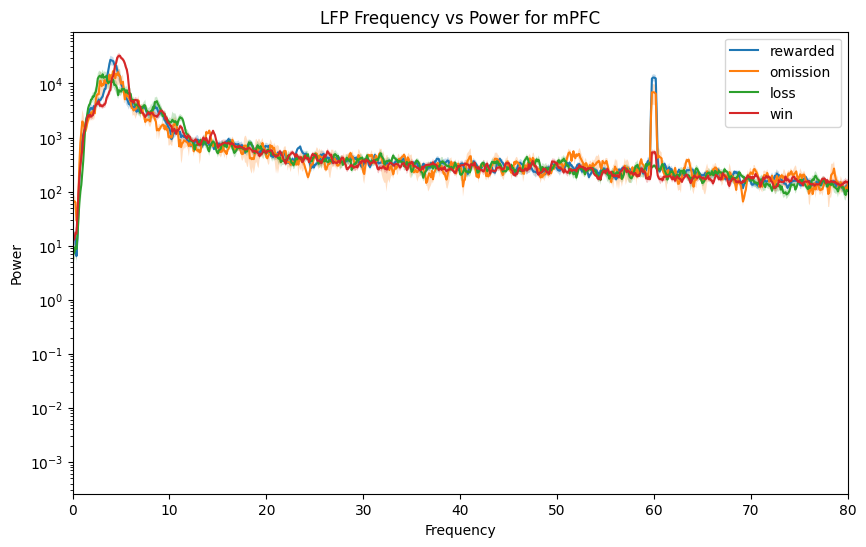

In [268]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label=tone_label)
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
ax.set_xlim(0,80)
ax.set_yscale("log")
# ax.set_ylim(0,60000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

Text(0.5, 1.0, 'LFP Frequency vs Power for mPFC')

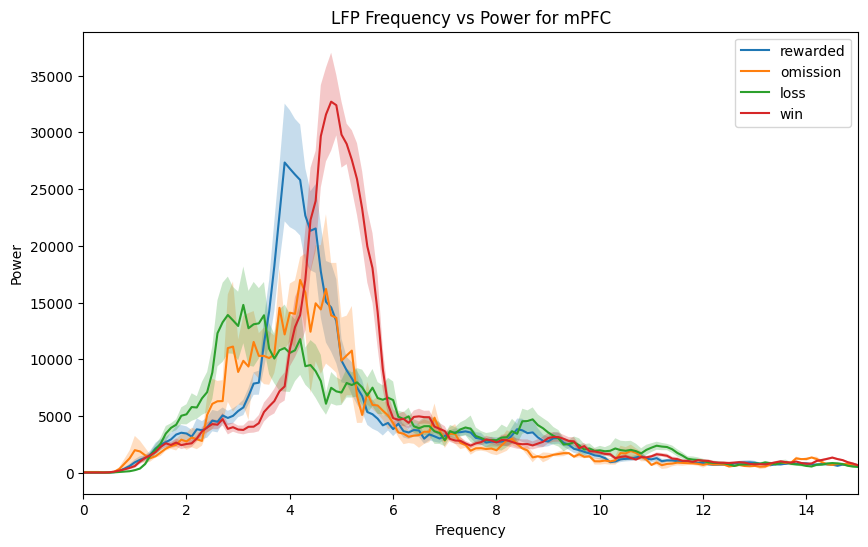

In [267]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label=tone_label)
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
ax.set_xlim(0,15)
# ax.set_yscale("log")
# ax.set_ylim(0,60000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [221]:
raise ValueError()

ValueError: 

# Part 4: Saving the Preprocessed files to folder

- Seeing which recording directories are already made

In [36]:
all_parent_recording_directories = glob.glob("./proc/*")

In [37]:
all_parent_recording_directories

['./proc/lfp_plot_recording_resample.svg',
 './proc/cmr_plot_recording_remove_bad_channels.svg',
 './proc/cmr_plot_recording_raw.png',
 './proc/lfp_plot_recording_bandpass.svg',
 './proc/cmr_plot_recording_remove_bad_channels.png',
 './proc/lfp_plot_recording_resample.png',
 './proc/lfp_plot_recording_bandpass.png',
 './proc/subject_6_1_omission_and_competition_with_6_3',
 './proc/lfp_plot_recording_raw.png',
 './proc/lfp_plot_recording_raw.svg',
 './proc/cmr_plot_recording_bandpass.svg',
 './proc/lfp_plot_recording_remove_bad_channels.png',
 './proc/cmr_plot_recording_bandpass.png',
 './proc/lfp_plot.svg',
 './proc/cmr_plot_recording_median_reference.png',
 './proc/cmr_plot_recording_median_reference.svg',
 './proc/lfp_plot_recording_remove_bad_channels.svg',
 './proc/cmr_plot_recording_raw.svg']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [38]:
parent_output_directory = all_parent_recording_directories[0]

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [39]:
preprocessing_output_directory = os.path.join(parent_output_directory, "preprocessing")


In [40]:
if not os.path.exists(preprocessing_output_directory):
    recording_intermediate.save_to_folder(name="preprocessing", folder=preprocessing_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(preprocessing_output_directory))

NotADirectoryError: [Errno 20] Not a directory: 'proc/lfp_plot_recording_resample.svg/preprocessing'

- Testing to see if everything was loaded correctly

In [ ]:
recording_test = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessing_output_directory)


In [ ]:
sw.plot_timeseries(recording_test, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)


In [ ]:
probe_group = recording_test.get_probegroup()

In [ ]:
plot_probe_group(probe_group, same_axes=False, with_channel_index=True)
plt.show()

# Other options and things to look at

In [ ]:
raise ValueError("Cells below are other options for preprocessing steps and visualizations. They take time and are still being tested, so running the rest of the notebook is not necessary. They are for those that want to look further into the recording data and the the preprocessing steps.")

## Computing Local Field Potential and Multi-Unit Activity

- "Local field potentials (LFP) are low frequency components of the extracellular recordings." 
- "Multi-unit activity (MUA) are rectified and low-pass filtered recordings showing the diffuse spiking activity."
    - https://spikeinterface.readthedocs.io/en/0.13.0/modules/toolkit/plot_1_preprocessing.html

In [ ]:
recording_lfp = st.preprocessing.bandpass_filter(recording_raw, freq_min=1, freq_max=300)
recording_mua = st.preprocessing.rectify(recording_raw)

In [ ]:
recording_lfp

In [ ]:
recording_mua

In [ ]:
f_lfp, p_lfp = scipy.signal.welch(recording_lfp.get_traces(segment_index=0)[:, 0], fs=fs)


In [ ]:
f_mua, p_mua = scipy.signal.welch(recording_mua.get_traces(segment_index=0)[:, 0], fs=fs)


In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_lfp, p_lfp, label="Local Field Potential")
ax.semilogy(f_mua, p_mua, label="Multi-Unit Activity")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

### Plotting Power Spectrum

- Now let’s plot the power spectrum of non-filtered, bandpass filtered, and notch filtered recordings.

In [ ]:
# The sampling frequency of the recording
fs = recording_raw.get_sampling_frequency()
fs

- Getting the power spectral density using Welch’s method for 0th segment
    - To access a given channel, index it like this: `recording_raw_traces[:, 0]` (0 is the number of the channel)
    - Commented out code is already ran, and the output is saved to a file to save time. Ur having issues with Jupyter Notebook not dying while running

In [ ]:
f_raw, p_raw = scipy.signal.welch(recording_raw.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_bandpass, p_bandpass = scipy.signal.welch(recording_bandpass.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_remove_bad_channels, p_remove_bad_channels = scipy.signal.welch(recording_remove_bad_channels.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_common_reference, p_common_reference = scipy.signal.welch(recording_common_reference.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_notch, p_notch = scipy.signal.welch(recording_notch.get_traces(segment_index=0)[:, 0], fs=fs)

- Plotting the power spectral density(https://en.wikipedia.org/wiki/Spectral_density)
    - Plotting the Semilog (https://www.mathworks.com/help/matlab/ref/semilogy.html) which plots the y-axis as powers of 10's
    - The X axis is the "Array of sample frequencies."
    - The Y axis is the "Power spectral density or power spectrum of X"
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_raw, p_raw, label="Raw")
ax.semilogy(f_bandpass, p_bandpass, label="Bandpass")
ax.semilogy(f_notch, p_notch, label="Notch")
ax.semilogy(f_remove_bad_channels, p_remove_bad_channels, label="Remove Bad Channels")
ax.semilogy(f_common_reference, p_common_reference, label="Common Reference")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

## Changing the Reference

- Rereferencing the signal to reduce the common mode noise from the recording
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html
- Average/median can be computed on different groups. 
- Single channels can also be used as reference.

In [ ]:
recording_car = st.common_reference(recording_raw, reference='global', operator='average')
recording_cmr = st.common_reference(recording_raw, reference='global', operator='median')

- Changing the reference and getting the reference causes the memory to run out of the computer so, commented out

In [ ]:
car_traces = recording_car.get_traces(segment_index=0)[:, 0]

In [ ]:
cmr_traces = recording_cmr.get_traces(segment_index=0)[:, 0]

In [ ]:
    else:
        metadata_exists = False
        warnings.warn("""No metadata was able to be extracted out of the file. 
    Either edit the code block above to match your format.
    Or change the format of the metadata to match something similar like these lines:  

    Description: Channel info for PHY data
    Byte_order: little endian
    Original_file: 02172021_BLA4-1_3_Competition_Rec.rec
    Clock rate: 20000
    Decimation: 1
    Number_of_channels: 32
    Fields: <nTrode int16><nTrodeChannel int16>")
    """)remove_bad_channelsfig, ax = plt.subplots()


ax.plot(car_traces, label = "Common average reference" )
ax.plot(cmr_traces, label = "Common median reference")
plt.legend()
plt.title("Title")
plt.xlabel("X Label")
plt.ylabel("Y Label")
plt.show()